# Visulalising clusters 

Now we have our clusters, we want to visualise them on global maps. Python has the best tools to do this

In [9]:
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from scipy import ndimage
xr.set_options(cmap_divergent='RdYlBl', cmap_sequential='tab20')

First let's read in our most important clusters that we have found previously

In [10]:
df = pd.read_csv('../data/csv/predictors_for_clusters_k35_ward.csv')

In [11]:
df.head()

,V1
0,nin3.1
1,mjopc1a.5
2,pdo.5
3,peu.1
4,nin3.5


We need to create a colorbar for our clusters as matplotlibs tabular colorbars stop at 20 colours. 

Here I've used some random numbers to create some unique colours, then used these to create the colourbar 

In [12]:
k = df.shape[0]
unique_colors = np.random.rand(k, 3)
cmap = ListedColormap(unique_colors)
bounds = np.linspace(0, 1, k+1)
norm = BoundaryNorm(bounds, cmap.N)

Since clusters have areas around the world, we need a nice way to find the centres of all of these points to plot labels over them on the map. 

Scipy's ndimage has some functions that will help us with this. We can label the data and then remove any bits of cluster that are particularly small. This helps us limit the number of labels we need. 

In [13]:
def drop_blobs_less_than_threshold(filtered_data, threshold = 20):
    Zlabeled,Nlabels = ndimage.label(filtered_data.values)
    label_size = [(Zlabeled == label).sum() for label in range(Nlabels + 1)]
    for label,size in enumerate(label_size):
        if size < threshold:
            filtered_data.values[Zlabeled == label] = 0
    return filtered_data


Now we can do our plotting

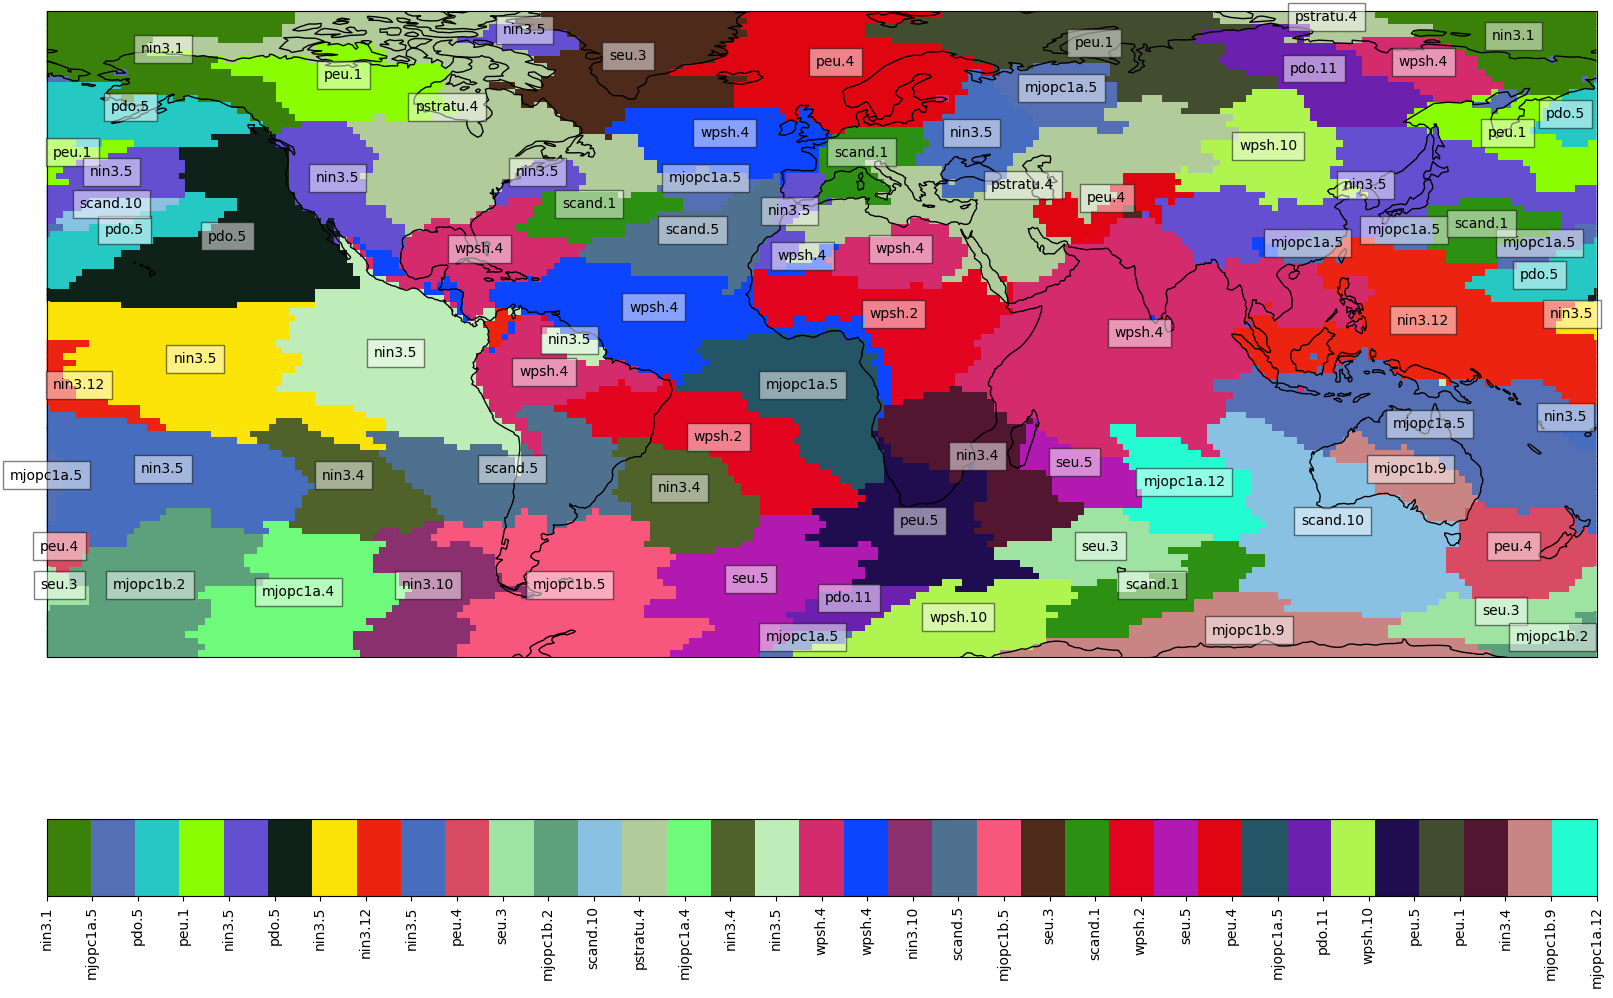

In [15]:
fig, axes = plt.subplots(1, 1 , figsize=(20, 14),subplot_kw={'projection': ccrs.PlateCarree()})

#cmap=plt.cm.get_cmap('tab20', k)
ds_k = xr.open_dataset(f'../data/netcdf/HiClimR_k{k}_ward_shortglobe.nc')
pcm = ds_k.region.plot.pcolormesh(ax=axes, transform=ccrs.PlateCarree(), x="lon", y="lat",
                            cmap = cmap, add_colorbar=False)

cbar = plt.colorbar(pcm, ax = axes, orientation = 'horizontal', ticks = ds_k.id)
cbar.set_ticks(ds_k.id)
cbar.set_ticklabels(df['V1'].to_numpy(), rotation = 90)
for cluster in range(1, k+1):
    mask = ds_k.region == cluster
    filtered_data = ds_k.region.where(mask, 0)
    filtered_data = drop_blobs_less_than_threshold(filtered_data)
    Zlabeled, Nlabels = ndimage.label(filtered_data.values)
    centres = ndimage.center_of_mass(filtered_data.values, Zlabeled, [i for i in range(1,Nlabels+1)])
    for centre in centres: 
        axes.text(ds_k.region['lon'].values[int(centre[1])],
                ds_k.region['lat'].values[int(centre[0])], 
                df['V1'].to_numpy()[cluster-1], 
                 bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5},
                 horizontalalignment  = 'center')
axes.coastlines()
